# NOTEBOOK 2 - Phasor diagrams

#### A quick introduction to the phasor diagrams in the dq frame. 
Note: Based on Task 1A from the 2017 exam

Still a work in progress, if there is anything missing or you have some general feedback please contact Sjur Føyen at foyen.sjur@ntnu.no 


Code implemented by; Varg Førland. Date; 29.01.2025

Last update; 10.02.2025

GitHub Copilot used for assistance in coding.

In [1]:
# IMPORTS. RUN FIRST!
import numpy as np
import matplotlib.pyplot as plt
# from ipywidgets import interact, IntSlider, FloatSlider
from notebook_utils import plot_phasor_diagram, update_phasor_diagram
from matplotlib.patches import Arc
#more

## System
A power plant is connected to an infinite grid as shown in the figure below and delivers 80 MW active power and 20 Mvar reactive power to grid. The power plant has a salient-pole generator, and the relevant parameters for the generator, transformer and transmission line are given in the table below:

![Figure1](Figures/System_Notebooks.png)

| **Category**               | **Parameter** | **Value**  | **Comment**                                                                 |
|----------------------------|---------------|------------|-----------------------------------------------------------------------------|
|                            |     | |                                                                             |
| **Generator Parameters**                          |
|   | $H$           | 5.0 seconds |                                                                             |
|                            | $D$           | 10.0 p.u.  | All per unit values are referred to $V_{\text{base}} = 132 \, \text{kV}$ and $S_{\text{base}} = 100 \, \text{MW}$ |
|                            | $X_q$         | 0.8 p.u.   |                                                                             |
|                            | $X_d$         | 1.0 p.u.   |                                                                             |
|                            | $X_d'$        | 0.3 p.u.   |                                                                             |
|                            | $T_{d0}'$     | 7.0 seconds |                                                                             |
|                            |  
|   **Transformer**                                                             |
|  | $X_t$         | 0.1 p.u.   | Nominal voltages: 17/132 kV, referred to $S_{\text{base}} = 100 \, \text{MW}$ |
|                            |  
|  **Transmission Line**                               |     | |                                                                             |
|  | $X_l$         | 0.1 p.u.   | Referred to $V_{\text{base}} = 132 \, \text{kV}$ and $S_{\text{base}} = 100 \, \text{MW}$ |
|                            |     | |                                                                             |





In [2]:
# System data Definitions:
# Base data
Sb = 100 # MVA
Vb_lv = 10 # kV
Vb_hv = 132 # kV
# pu conversion
Vs_kV = 132 + 0j # kV < deg
Vs = Vs_kV / Vb_hv # pu
P_MW = 80 # MW delivered power to network 
Q_MVAR = 20 #MVAR delivered power to network
P = P_MW / Sb # pu
Q = Q_MVAR / Sb # pu

#Transformer data
Xt =  0.1 # pu

#Generator data
H = 10 # s
D = 10 # pu
Xq = 0.8 # pu
Xd = 1.0 # pu
Xd_t = 0.3 # pu (_t means transient) (_st means subtransient)
Td0_t = 7.0 # s

#Line data
Xl = 0.1 # pu

## Phasor calculations

To calculate the phasor, we first need to know the relevant values. We want to find and draw
- $V_g$, voltage at the generator terminal
- $V_t$, voltage at the HV side of the transformer
- $E_q$, steady-state emf
- $E_q'$, transient emf
- $I$ and the dq components $I_q$ and $I_d$

#### Equivalent reactances
First we find the equivalent reactances in the dq direction. We can find these if we draw the reactances in a circuit diargam. The reactances are in series and can be defined as
- $x_q = X_q + X_t + X_l$
- $x_d = X_d + X_t + X_l$
- $x_d'= X_d'+ X_t + X_l$

In [3]:
xq = Xq + Xt + Xl
xd = Xd + Xt + Xl
xd_t = Xd_t + Xt + Xl

print('xq = ', xq)
print('xd = ', xd)
print('xd_t = ', xd_t)

xq =  1.0
xd =  1.2000000000000002
xd_t =  0.5


### Current - $I$
As we have the delivered power, and voltage at the infinte bus, we can easily calculate the current as 
- $S = VI^*$, which gives us $I = \frac{P-jQ}{V_s}$

This calculation gives is the current in the $ab$-frame, so that
- $I = I_a + j I_b$ = $|I| \angle \phi$ 

To express $I$ by dq-components, we first need to find the emf to which we refer the dq-frame.


In [4]:
from IPython.display import display, Math

I = (P - 1j*Q) / Vs
phi = np.abs(np.angle(I))

display(Math(r'I = {0:.4f} {1:.4f} j'.format(np.real(I), np.imag(I))))
display(Math(r'I = {0:.4f} \angle {1:.2f}^\circ'.format(abs(I), -phi*180/np.pi)))
display(Math(r'\phi = {0:.2f}^\circ'.format(phi*180/np.pi)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Voltages - $V_t$ and $V_g$ 
To calulate the bus voltages we simply consider the voltage drop across the line and transformer. We then simply express them as
- $V_t = V_s + I \cdot Z_{line} = V_s + I \cdot j X_{l}$
- $V_g = V_s + I \cdot (Z_{line} + Z_{transformer}) = V_s + I \cdot j (X_{l} + X_{t})$


In [5]:
Vt = Vs + I * 1j*(Xl)
Vg = Vs + I * 1j*(Xt + Xl)

display(Math(r'V_t = {0:.4f} \angle {1:.2f}^\circ'.format(abs(Vt), np.angle(Vt)*180/np.pi)))
display(Math(r'V_g = {0:.4f} \angle {1:.2f}^\circ'.format(abs(Vg), np.angle(Vg)*180/np.pi)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Steady state and transient power angle - $\delta / \delta'$
To find the power angle we use the vector $E_Q$, which is a vector used to find the initial rotor angle in a salient pole generator. We use this q-axis parallel vector to extract the value. We find $E_Q$ through the drop from the voltage source using the equivalent reactance $x_q$,
- $E_Q = V_s + I \cdot j x_q$

or the drop from the generator using the reactance $X_q$ and the terminal voltage
- $E_Q = V_g + I \cdot j X_q$.
Using the voltage drop all the way from the network is only valid if the current is the same throughout the system i.e. there is no local load.

This gives us $\delta$ as the $E_Q$ vector will be aligned with the q-axis. We simply retrieve the angle of the phasor, and get the power angle as 
- $\delta = \text{Arg}(E_Q) = \tan^{-1}\left(\frac{\text{imag}(E_Q)}{\text{real}(E_Q)}\right)$.

For a salient pole generator we can assume that the transient power angle is the same as the steady state, i.e.
- $\delta = \delta'$


In [6]:
# and the internal voltage of the generator is then found by finding the angle through EQ for the q-axis (machowski Equation 3.64/3.66 (2nd/3rd edition))
EQ = Vs + I*1j*(xq) # pu
# angle
delta = np.angle(EQ) # rad


display(Math(r'\delta = {0:.2f}^\circ'.format(delta*180/np.pi)))

<IPython.core.display.Math object>

### dq-Current - $I_d$ and $I_q$
We now want to refer the current to the dq-frame of the induced emf. We start by finding the angle between the q-axis and the current, $\beta$. We find this simply by considering the power angle and angle of current as
- $\beta = \delta + \phi$

We can then find the length of the $I_d$ and $I_q$ phasors by decomposing it using the angle as
- $|I_d| = |I|sin(\beta)$
- $|I_q| = |I|cos(\beta)$

We already now their "angle" as they are referred to the q-axis which has the angle $\delta$, and the "negative" d-axis which has the angle $\delta - 90$ as it is normal on the q axis. 
- $I_d = |I|sin(\beta) \angle \delta - 90 $
- $I_q = |I|cos(\beta) \angle \delta$



In [7]:
beta = delta + phi # rad

Id_m = np.abs(I)*np.sin(beta) 
Iq_m = np.abs(I)*np.cos(beta)

Id = Id_m * np.exp(1j*(delta - np.pi/2))
Iq = Iq_m * np.exp(1j*(delta))

display(Math(r'I_d = {0:.4f} \angle {1:.2f}^\circ'.format(abs(Id), np.angle(Id)*180/np.pi)))
display(Math(r'I_q = {0:.4f} \angle {1:.2f}^\circ'.format(abs(Iq), np.angle(Iq)*180/np.pi)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Emf - $E_q$ and $E_q'$  
We now find the induced emf and transient emf by exploting the phasor geometry. They are given by 
- $E_q = V_g + I_d \cdot j X_d + I_q \cdot  j X_q $
- $E_q' = V_g + I_d \cdot j X_d' + I_q \cdot  j X_q $ @haralddj STEMMER DETTE? VURDERER Å DROPPE Eq transient i eksempelet her

A good way to know wether or not the value is correct is to check if the angle og $E_q$ is $\delta$.

In [8]:
Eq = Vg + Id*1j*(Xd) + Iq*1j*Xq # pu
Eq_t = Vs + Id*1j*(xd_t) + Iq*1j*xq # pu


display(Math(r'E_q = {0:.4f} \angle {1:.2f}^\circ'.format(abs(Eq), np.angle(Eq)*180/np.pi)))
display(Math(r'E_qt = {0:.4f} \angle {1:.2f}^\circ'.format(abs(Eq_t), np.angle(Eq_t)*180/np.pi)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Drawing the diagram 
To draw the phasor diagram, we will use the `plot_phasor_diagram` function with the calculated phasors.

Try to change the values of the system, and see how the diagram changes. What parameters effects what phasors?

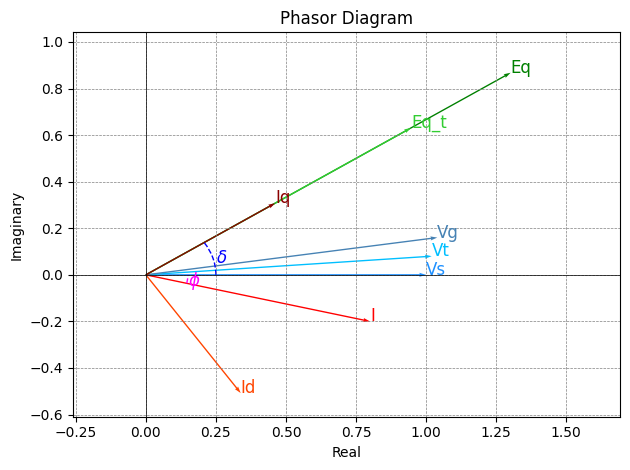

In [9]:

phasors = {
    'Vs': Vs,
    'Vt': Vt,
    'Vg': Vg,
    'Eq': Eq,
    'Eq_t': Eq_t,
    'I': I,
    'Id': Id,
    'Iq': Iq
}

xlim = (-max(np.real(value) for value in phasors.values())*0.2, max(np.real(value) for value in phasors.values())*1.3)
ylim = (min(np.imag(value) for value in phasors.values())*1.2,max(np.imag(value) for value in phasors.values())*1.2)

plot_phasor_diagram(phasors, xlim=xlim, ylim=ylim)

## Interactive plot

Below you can tweak values using the sliders to see how it impacts the phasor diagram

In [10]:
import ipywidgets as widgets
from ipywidgets import interact


# Create sliders for the variables
Vs_slider = widgets.FloatSlider(value=1.0, min=0, max=2, step=0.1, description='Vs')
P_slider = widgets.FloatSlider(value=0.8, min=0, max=1.5, step=0.05, description='P')
Q_slider = widgets.FloatSlider(value=0.2, min=-1, max=1, step=0.05, description='Q')
Xd_slider = widgets.FloatSlider(value=1.0, min=0, max=2, step=0.1, description='Xd')
Xd_t_slider = widgets.FloatSlider(value=0.3, min=0, max=2, step=0.1, description='Xd_t')
Xq_slider = widgets.FloatSlider(value=0.8, min=0, max=2, step=0.1, description='Xq')
Xt_slider = widgets.FloatSlider(value=0.1, min=0, max=2, step=0.1, description='Xt')
Xl_slider = widgets.FloatSlider(value=0.1, min=0, max=2, step=0.1, description='Xl')

# Use interact to create the interactive plot
interact(update_phasor_diagram, P=P_slider, Q=Q_slider, Vs = Vs_slider, Xd=Xd_slider, Xd_t=Xd_t_slider, Xq=Xq_slider, Xt=Xt_slider, Xl=Xl_slider)

interactive(children=(FloatSlider(value=0.8, description='P', max=1.5, step=0.05), FloatSlider(value=0.2, desc…

<function notebook_utils.update_phasor_diagram(P, Q, Vs, Xd, Xd_t, Xq, Xt, Xl)>